<a href="https://colab.research.google.com/github/decoderkurt/HUF_RL_2022/blob/main/24/simple_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir PPO

In [2]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='PPO'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='PPO'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               



In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


... saving models ...
episode 0 score 22.0 avg score 22.0 time_steps 22 learning_steps 1
episode 1 score 11.0 avg score 16.5 time_steps 33 learning_steps 1
episode 2 score 27.0 avg score 20.0 time_steps 60 learning_steps 3
episode 3 score 15.0 avg score 18.8 time_steps 75 learning_steps 3
episode 4 score 13.0 avg score 17.6 time_steps 88 learning_steps 4
episode 5 score 14.0 avg score 17.0 time_steps 102 learning_steps 5
episode 6 score 8.0 avg score 15.7 time_steps 110 learning_steps 5
episode 7 score 10.0 avg score 15.0 time_steps 120 learning_steps 6
episode 8 score 14.0 avg score 14.9 time_steps 134 learning_steps 6
episode 9 score 15.0 avg score 14.9 time_steps 149 learning_steps 7
episode 10 score 16.0 avg score 15.0 time_steps 165 learning_steps 8
episode 11 score 13.0 avg score 14.8 time_steps 178 learning_steps 8
episode 12 score 15.0 avg score 14.8 time_steps 193 learning_steps 9
episode 13 score 15.0 avg score 14.9 time_steps 208 learning_steps 10
episode 14 score 12.0 avg s

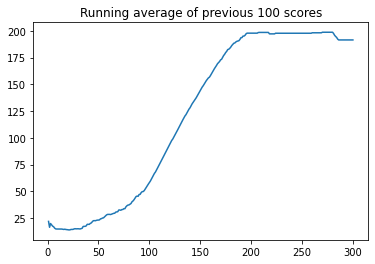

In [4]:
import gym
import numpy as np

env = gym.make('CartPole-v0')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                alpha=alpha, n_epochs=n_epochs, 
                input_dims=env.observation_space.shape)
n_games = 300

figure_file = 'PPO/cartpole.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
            'time_steps', n_steps, 'learning_steps', learn_iters)
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)

